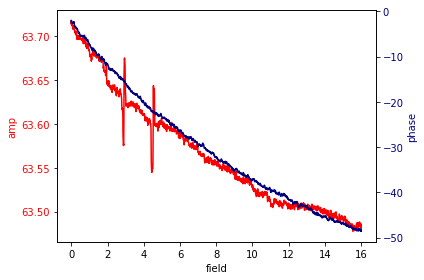

do you want to look for jumps? [y/n/end] n


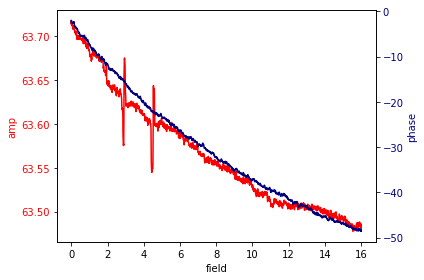

what changes do you want to make (flip amplitude/ swap phase and amplitude/ end/ continue without doing anything) [f/s/end/hit Enter]? 
enter the minimum and maximum values of the peaks separated by commas (i.e. min1,max1,min2,max2,...): 2,5
what order polynomial do you want to fit to the data? 2


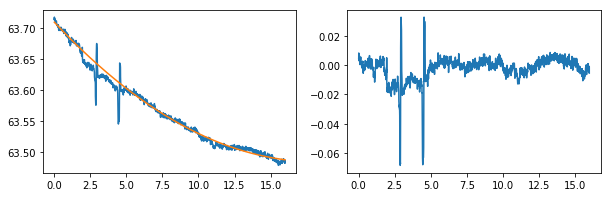

are you happy with the subtracted curve? [y/n/end/new]: y
perfect


In [7]:
# this package needs to be loaded to open a file dialogue to open the data file
#from tkinter import filedialog
#from tkinter import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import os.path
import sys

%matplotlib inline


# opening a dialogue to open a file
#root = Tk()
#root.withdraw()

# this gives the folder that will be opened with the dialogue
#initialdirection = "C:\\Users\\j111\\Nextcloud\\Klingeler_Masterarbeit\\howardevansite\\NaCuFe2(VO4)3 powder\\data fixed powder\\"
#filename =  filedialog.askopenfilename(initialdir = initialdirection,title = "Select file",filetypes = (("all files","*.*"),("all files","*.*")))
#filename = filename.replace('/','\\')


folder = "C:\\Users\\F25_1.307_b\\Dropbox\\Klingeler_Masterarbeit\\rare earth tetraborides\\ESR\\"
name = "NdB4\\test_Jan_20\\20K\\F245p6T20K-u"
filename = folder+name


# this paragraph extracts parts of the filename
# in particular it extracts the freqeuncy and temperature at which the measurement was done
# this information is saved in the variable comment so I can write it in the respective column at the end when saving the new file
# since temperature sweeps and individual measurements are named differently I have to distinguish those two cases below
namefile = filename[::-1]
position = namefile.find('\\')
file = filename[-position:]

# temperature sweep
if file[0] == '-':
	namefile = filename[::-1]
	position = namefile.find('\\')
	file = filename[-position:]

	fb = file.find('F')
	fe = file.find('G')
	Tb = file.find('T')
	Te = file.find('K')

	comment = file[Tb+1:Te]+'K '+file[fb+1:fe]+'GHz'

# individual measurement	
else:
	F = file.find('F')
	p = file.find('p')
	T = file.find('T')
	K = file.find('K')
	
	if file[F+1] == '0':

		frequency = file[F+2:p]+'.'+file[p+1:T]+'GHz'
	else:
		frequency = file[F+1:p]+'.'+file[p+1:T]+'GHz'

	if file[T+1] == '0':
		Temp = file[T+2:K+1]
	else:
		Temp = file[T+1:K+1]
	
	comment = Temp+' '+frequency


# in the following the file is read in and the columns of data are extracted
# here I am defining empty arrays for the different columns of the data file 
# field in T
field = []
# amplitude in db
amp=[]
# phase in °
phase = []
# temperature in K
temp=[]
# real part
real=[]
# imaginary part
imaginary=[]



f = open(filename, 'r')
f.readline()
f.readline()
for line in f:
    line=line.strip()
    line=line.split()
    field.append(float(line[1]))
    amp.append(float(line[2]))
    phase.append(float(line[3]))
    real.append(float(line[4]))
    imaginary.append(float(line[5]))
    temp.append(float(line[0]))

field = np.array(field)
amp = np.array(amp)
phase = np.array(phase)
temp = np.array(temp)
real = np.array(real)
imaginary = np.array(imaginary)


# ##################################################################################################################################################################
# ##################################################################################################################################################################
# ##################################################################################################################################################################
# the next section removes jumps from the data 
# I will first remove jumps from the phase 

# first of all the data is plotted
fig, ax1 = plt.subplots()

ax1.set_xlabel('field')
ax1.set_ylabel('amp', color = 'red')
ax1.plot(field, amp, color = 'red')
ax1.tick_params(axis='y', labelcolor = 'red')

ax2 = ax1.twinx()

ax2.set_ylabel('phase', color = 'navy')
ax2.plot(field, phase, color = 'navy')
ax2.tick_params(axis='y', labelcolor = 'navy')

fig.tight_layout()
plt.show()


# and before we do anything from here, do you even want to look for jumps?
# - y/n for yes/no
# - end the code (end) (you can do this every time you are asked for input - even if not explicitly mentioned)

question = input('do you want to look for jumps? [y/n/end] ')

if question == 'end':
	sys.exit()


if question == 'y':
# I am taking the first (dphase) and second (ddphase) derivative of the phase to see jumps more clearly
# I will later use that continuous signals usually flatten with higher derivatives whereas jumps don'taking
# another reason for using the second and not the first derivative is that at a jump the second derivative will
# show two peaks (one positive and one negative) whereas there will be only one at the first derivative
# this gives us another criteria to distinguish between jumps and just big but continuous derivatives

# note that I am not really taking a derivative since I am not deviding by deltaB, but assuming that the field steps
# are equidistant that will only result in an overall factor

# first derivative
	dphase = []
	for i in np.arange(len(phase)):
		if i < len(phase)-1:
			dphase.append(phase[i+1]-phase[i])
		else:
			dphase.append(phase[i]-phase[i-1])

	dphase = np.array(dphase)

# second derivative
	ddphase = []
	for i in np.arange(len(phase)):
		if i < len(phase)-1:
			ddphase.append(dphase[i+1]-dphase[i])
		else:
			ddphase.append(dphase[i]-dphase[i-1])
	ddphase = np.array(ddphase)


# in this step I am calculating the mean and standard deviation of the second derivative
	ave = np.mean(abs(ddphase))
	std = np.std(abs(ddphase))


# here I am finding the jumps (i.e their indices in the respective arrays)
# jumps are features that are "deviation" times the standard deviation away from the mean of the second derivative
	deviation = 5


# note that jumps also need to have two features right next to each other
# remember: 0th derivative: jump
#			1st derivative: 1 peak
#			2nd derivative: 2 peaks right next to each other with opposite sign

# for now this condition is fulfilled (because deviation=3)
# I am using this while loop to being able to repeat the following step several times if I am not happy with the outcome
# what I can change in between the different tries is "deviation"
	while deviation != '':

# index gives you an array with the indices of suspeected jumps
# if there is no jump suspected this array will be empty
# in order to distinguish the case of no jump and several jumps the condition len(index)>0 will be posed several times in the following
		index = np.arange(len(phase))[abs(ddphase)>ave+float(deviation)*std]

# this is the case of several jumps
		if len(index) > 0:
# I am checking if there are pairs of jumps right next to each other
			mask = [False]
			for i in (np.arange(len(index)-1)+1):
				if index[i-1] == index[i]-1:
					mask.append(True)
				else:
					mask.append(False)

# index finally gives you the indices of the jumps	
			index1 = index[mask]


# now I am plotting the phase and dots on top of it where jumps are suspected
# jumpsx and y give the phase and field of the jump
# note that the jump occurs from the index given in index1 to the following data point
# for plotting a dot where the jump is expected using the average values is most convenient
			jumpsx = [(field[i]+field[i+1])/2 for i in index1]
			jumpsy = [(phase[i]+phase[i+1])/2 for i in index1]

			plt.plot(field, phase, zorder = 0)
			plt.scatter(jumpsx, jumpsy, color='r', zorder=1, s=8)
			plt.show()


# now based on the plot above I am asking you whether the dots actually mark jumps
# your answer options are:
# - consecutive letters of 'n' and 'y' (e.g. nnyyyyny) for each dot from left to right; those will be the jumps that are removed in the following
# - enter a number; this number will be a new value for "deviation" and we will repeat the search for jumps with this different value 
# - enter 'end': this will interrupt the python code - note that you can do this at any point you are asked for input
# - hit enter and you will continue with the amplitude
			jumps = input('which of the marked points are actually jumps (enter y/n for jump/no jump)? Or do you maybe want to change the number of standard deviations the jump has to be away from the mean (enter a number)? ' )
			if jumps == '':
				deviation = ''
				index = []
			elif jumps[0] == 'n' or jumps[0] == 'y':
				deviation = ''
			elif jumps == 'end':
				sys.exit()
			else:
				deviation = float(jumps)

# this is the case of no jump; you have two options here:
# - hit enter to continue with the same process for the amplitude
# - enter a number; this number will replace the old value for "deviation" and the process of finding jumps will be repeated
		else:
			deviation = input('No jump was found. Do you want to continue with the amplitude (press Enter) or change the numbers of standard deviations the jump has to be away from the mean (enter a number)? ')
			if deviation == 'end':
				sys.exit()
		
		
		
# if there was no jump found and you chose to continue with the amplitude then len(index) will still be zero so the code inside
# the if-loop will not be executed
# otherwise it will be >0

	if len(index)>0:

# from the string jumps that says 'y'/'n' if there is/isn't a jump a mask (manual_mask) is created
		manualmask = []
		for i in jumps:
			if i == 'n':
				manualmask.append(False)
			elif i == 'y':
				manualmask.append(True)

# index2 now really gives the indeces of the jumps
		index2 = index1[manualmask]

# this is where the jumps in the phase are actually eliminated
		phase_new = phase
# only if there are any jumps left and you didn't tell it that all the suspected points are in fact not jumps
		if len(index2)>0:
# for all the jumps
			for i in index2:
# I am creating an array that is 0 before and 1 after the jump is happening
				a = np.zeros(len(phase))
				for k in np.arange(len(phase)):
					if k > i:
						a[k] = 1
# with this array I can just add the jump to all the values after it
				phase_new = phase_new + (phase[i]-phase[i+1])*a



		plt.plot(field, phase_new)
		plt.show()
	
		phase = phase_new




# ##################################################################################################################################################################
# ##################################################################################################################################################################
# ##################################################################################################################################################################
# now I will do the same thing for the amplitude
	damp = []
	for i in np.arange(len(amp)):
		if i < len(amp)-1:
			damp.append(amp[i+1]-amp[i])
		else:
			damp.append(amp[i]-amp[i-1])

	damp = np.array(damp)

	ddamp = []
	for i in np.arange(len(amp)):
		if i < len(amp)-1:
			ddamp.append(damp[i+1]-damp[i])
		else:
			ddamp.append(damp[i]-damp[i-1])
	ddamp = np.array(ddamp)


	ave = np.mean(abs(ddamp))
	std = np.std(abs(ddamp))


	deviation = 5

	while deviation != '':
		index = np.arange(len(amp))[abs(ddamp)>ave+float(deviation)*std]
		if len(index) > 0:
			mask = [False]
			for i in (np.arange(len(index)-1)+1):
				if index[i-1] == index[i]-1:
					mask.append(True)
				else:
					mask.append(False)
	
			index1 = index[mask]

			jumpsx = [(field[i]+field[i+1])/2 for i in index1]
			jumpsy = [(amp[i]+amp[i+1])/2 for i in index1]

			plt.plot(field, amp, zorder = 0)
			plt.scatter(jumpsx, jumpsy, color='r', zorder=1, s=8)
			plt.show()


			jumps = input('which of the marked points are actually jumps (enter y/n for jump/no jump)? Or do you maybe want to change the number of standard deviations the jump has to be away from the mean (enter a number)? ' )
			if jumps == '':
				deviation = ''
				index = []
			elif jumps[0] == 'n' or jumps[0] == 'y':
				deviation = ''
			elif jumps == 'end':
				sys.exit()
			else:
				deviation = float(jumps)

		else:
			deviation = input('No jump was found. Do you want to continue with the amplitude (press Enter) or change the numbers of standard deviations the jump has to be away from the mean (enter a number)? ')
			if deviation == 'end':
				sys.exit()

		

	if len(index)>0:
		manualmask = []
		for i in jumps:
			if i == 'n':
				manualmask.append(False)
			elif i == 'y':
				manualmask.append(True)
		index2 = index1[manualmask]
	
		amp_new = amp
		if len(index2)>0:
			for i in index2:
				a = np.zeros(len(amp))
				for k in np.arange(len(amp)):
					if k > i:
						a[k] = 1
				amp_new = amp_new + (amp[i]-amp[i+1])*a



		plt.plot(field, amp_new)
		plt.show()
	
		amp = amp_new





# ##################################################################################################################################################################
# ##################################################################################################################################################################
# ##################################################################################################################################################################
# in this section I am performing slight phase corrections if necessary
# that means: swapping phase and amplitude, multiplying phase or amplitude with a minus sign

# first of all the data is plotted
fig, ax1 = plt.subplots()

ax1.set_xlabel('field')
ax1.set_ylabel('amp', color = 'red')
ax1.plot(field, amp, color = 'red')
ax1.tick_params(axis='y', labelcolor = 'red')

ax2 = ax1.twinx()

ax2.set_ylabel('phase', color = 'navy')
ax2.plot(field, phase, color = 'navy')
ax2.tick_params(axis='y', labelcolor = 'navy')

fig.tight_layout()
plt.show()


# here you are asked if there is anything you want to do with the data
# your options are:
# - f: flips the amplitude
# - s: swaps the amplitude with the phase
# - any combination of those two
# - end: interrupt the code
# - hit enter: continue without doing anything
flip = input('what changes do you want to make (flip amplitude/ swap phase and amplitude/ end/ continue without doing anything) [f/s/end/hit Enter]? ')
for i in flip:
	if i == 'f':
		amp = - amp
	
	elif i == 'p':
		ampnew = phase
		phasenew = amp
	
		phase = phasenew
		amp = ampnew
	
if flip =='end':
	sys.exit()

if flip != '':	
	fig, ax1 = plt.subplots()

	ax1.set_xlabel('field')
	ax1.set_ylabel('amp', color = 'red')
	ax1.plot(field, amp, color = 'red')
	ax1.tick_params(axis='y', labelcolor = 'red')

	ax2 = ax1.twinx()

	ax2.set_ylabel('phase', color = 'navy')
	ax2.plot(field, phase, color = 'navy')
	ax2.tick_params(axis='y', labelcolor = 'navy')

	fig.tight_layout()
	plt.show()






	
# ##################################################################################################################################################################
# ##################################################################################################################################################################
# ##################################################################################################################################################################	
# here I am subtacting a polynomial baseline from the amplitude data

# this defines a 9th order polynomial
def polynomial(x, a, b, c, d, e, f, g, h, i, j):
    return (a*x**9 + b*x**8 + c*x**7 + d*x**6 + e*x**5 + f*x**4 + g*x**3 + h*x**2 + i*x + j)

# this function fits an n-th order polynomial to the amplitude data
# input variable of the function are:
# - n: the order of the polynomial you want to fit to the data
# - xmin: an array of the minimum field values of the signals you want to take out of the fit
# - xmax: ... maximum ...
# - the amplitude
# - the field
def fitpolynomial(n, xmin, xmax, amp, field):
    mask = np.array([[any([(field<xmin[j])[i],(field>xmax[j])[i]]) for i in np.arange(len(field))] for j in np.arange(len(xmax))])
    mask = [all([mask[j,i] for j in np.arange(len(xmax))]) for i in np.arange(len(field))]
    fieldcut = field[mask]
    ampcut = amp[mask]

    if n == 9:
        def fct(x, a, b, c, d, e, f, g, h, i, j):
            return polynomial(x, a, b, c, d, e, f, g, h, i, j)
        parameters, pcov = curve_fit(fct, fieldcut, ampcut)
        fit = fct(field, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5], parameters[6], parameters[7], parameters[8], parameters[9])
           
    elif n==8:
        def fct(x, b, c, d, e, f, g, h, i, j):
            return polynomial(x, 0, b, c, d, e, f, g, h, i, j)
        parameters, pcov = curve_fit(fct, fieldcut, ampcut)
        fit = fct(field, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5], parameters[6], parameters[7], parameters[8])
           
    elif n==7:
        def fct(x, c, d, e, f, g, h, i, j):
            return polynomial(x, 0, 0, c, d, e, f, g, h, i, j)
        parameters, pcov = curve_fit(fct, fieldcut, ampcut)
        fit = fct(field, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5], parameters[6], parameters[7])
         
    elif n==6:
        def fct(x, d, e, f, g, h, i, j):
            return polynomial(x, 0, 0, 0, d, e, f, g, h, i, j)
        parameters, pcov = curve_fit(fct, fieldcut, ampcut)
        fit = fct(field, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5], parameters[6])
               
    elif n==5:
        def fct(x, e, f, g, h, i, j):
            return polynomial(x, 0, 0, 0, 0, e, f, g, h, i, j)
        parameters, pcov = curve_fit(fct, fieldcut, ampcut)
        fit = fct(field, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5])
               
    elif n==4:
        def fct(x, f, g, h, i, j):
            return polynomial(x, 0, 0, 0, 0, 0, f, g, h, i, j)
        parameters, pcov = curve_fit(fct, fieldcut, ampcut)
        fit = fct(field, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4])
              
    elif n==3:
        def fct(x, g, h, i, j):
            return polynomial(x, 0, 0, 0, 0, 0, 0, g, h, i, j)
        parameters, pcov = curve_fit(fct, fieldcut, ampcut)
        fit = fct(field, parameters[0], parameters[1], parameters[2], parameters[3])
        
    elif n==2:
        def fct(x, h, i, j):
            return polynomial(x, 0, 0, 0, 0, 0, 0, 0, h, i, j)
        parameters, pcov = curve_fit(fct, fieldcut, ampcut)
        fit = fct(field, parameters[0], parameters[1], parameters[2])
                        
    elif n==1:
        def fct(x, i, j):
            return polynomial(x, 0, 0, 0, 0, 0, 0, 0, 0, i, j)
        parameters, pcov = curve_fit(fct, fieldcut, ampcut)
        fit = fct(field, parameters[0], parameters[1])
            
    ampsubtract = amp - fit
    return (ampsubtract, fit)


	


#min = input('enter the minimum values of the peaks separated by commas: ')

#if min == 'end':
#	sys.exit()

#max = input('enter the maximum values of the peaks separated by commas: ')

#if max == 'end':
#	sys.exit()
    
pos = input('enter the minimum and maximum values of the peaks separated by commas (i.e. min1,max1,min2,max2,...): ')

if pos == 'end':
	sys.exit()
    

#xmin = []
#xmax = []

#for i in np.arange(min.count(',')):
#	a = min.find(',')
#	b = max.find(',')

#	xmin.append(float(min[:a]))
#	xmax.append(float(max[:b]))
#	
#	min = min[a+1:]
#	max = max[b+1:]
#xmin.append(float(min))
#xmax.append(float(max))

allpos = []
for i in np.arange(pos.count(',')):
    a = pos.find(',')
    allpos.append(float(pos[:a]))
    pos = pos[a+1:]

    allpos.append(float(pos))

xmin = allpos[::2]
xmax = allpos[1::2]


happy = 'n'


while happy=='n':
	
	n = float(input('what order polynomial do you want to fit to the data? '))
	
	ampsubtract = fitpolynomial(n, xmin, xmax, amp, field)[0]
	fitpoly = fitpolynomial(n, xmin, xmax, amp, field)[1]

	fig = plt.figure(figsize=[10,3])
	ax1 = fig.add_subplot(1,2,1)
	ax2 = fig.add_subplot(1,2,2)

	ax1.plot(field, amp)
	ax1.plot(field, fitpoly)

	ax2.plot(field, ampsubtract)
	
	plt.show()

	happy = input('are you happy with the subtracted curve? [y/n/end/new]: ')
	
	if happy == 'end':
		break
	
	if happy == 'new':
		fig, ax1 = plt.subplots()

		ax1.set_xlabel('field')
		ax1.set_ylabel('amp', color = 'red')
		ax1.plot(field, amp, color = 'red')
		ax1.tick_params(axis='y', labelcolor = 'red')

		ax2 = ax1.twinx()

		ax2.set_ylabel('phase', color = 'navy')
		ax2.plot(field, phase, color = 'navy')
		ax2.tick_params(axis='y', labelcolor = 'navy')

		fig.tight_layout()
		plt.show()

        pos = input('enter the minimum and maximum values of the peaks separated by commas (i.e. min1,max1,min2,max2,...): ')
		allpos = []
        for i in np.arange(pos.count(',')):
            a = pos.find(',')
            allpos.append(float(pos[:a]))
            pos = pos[a+1:]
        
        allpos.append(float(pos))
        
        xmin = allpos[::2]
        xmax = allpos[1::2]
		
		happy = 'n'
        
## here I am just creating versions of the amplitude and phase which are normalized to 1
amp_norm = ampsubtract / np.absolute(max(ampsubtract) - min(ampsubtract))
phase_norm = phase / np.absolute(max(phase) - min(phase))

	
	
if happy == 'y':
	
	filenamenew = filename+'_processed.txt'
	
	if os.path.isfile(filenamenew) == True:
		x='w'
	else:
		x='x'

	with open(filenamenew, x) as g:
		g.write('Field'+'\t'+'Amp norm.'+'\t'+'Phase norm.'+'\t'+'Amp'+'\t'+'Phase'+'\t'+'Amp raw'+'\t'+'T2'+'\t'+'RealPart'+'\t'+'ImaginaryPart'+'\n')
		g.write('T'+'\t'+'dB'+'\t'+'°'+'\t'+'dB'+'\t'+'°'+'\t'+'dB'+'\t'+'K'+'\t'+''+'\t'+''+'\n')
		g.write(''+'\t'+comment+'\t'+'normalized'+'\t'+'not normalized'+'\t'+'not normalized'+'\t'+'raw data'+'\t'+''+'\t'+''+'\t'+''+'\n')
		for i in np.arange(len(field)):
			g.write(str(field[i])+'\t'+str(amp_norm[i])+'\t'+str(phase_norm[i])+'\t'+str(ampsubtract[i])+'\t'+str(phase[i])+'\t'+str(amp[i])+'\t'+str(temp[i])+'\t'+str(real[i])+'\t'+str(imaginary[i])+'\n')
	
	print('perfect')